In [1]:
from google.colab import drive
import zipfile, shutil, os

drive.mount('/content/drive')
shutil.copy("/content/drive/MyDrive/DATASET.zip", "/content/")
with zipfile.ZipFile("DATASET.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")
os.listdir("dataset")

Mounted at /content/drive


['DATASET']

In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
def load_images_from_folder(folder_path, image_size=(224, 224)):
    X, y = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            try:
                img_path = os.path.join(class_folder, filename)
                img = Image.open(img_path).convert('RGB').resize(image_size)
                X.append(np.array(img))
                y.append(class_map[class_name])
            except:
                continue
    return np.array(X), np.array(y), class_map

X, y, class_map = load_images_from_folder("dataset/DATASET")
X = preprocess_input(X.astype(np.float32))  # VGG16 preprocessing

class_names = list(class_map.keys())

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_map), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2155 - loss: 2.7888 - val_accuracy: 0.4150 - val_loss: 2.1371
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 497ms/step - accuracy: 0.3129 - loss: 2.3369 - val_accuracy: 0.6000 - val_loss: 1.2732
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 501ms/step - accuracy: 0.4722 - loss: 1.6677 - val_accuracy: 0.7300 - val_loss: 0.8802
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - accuracy: 0.5267 - loss: 1.5526 - val_accuracy: 0.7700 - val_loss: 0.6892
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.6478 - loss: 1.1251 - val_accuracy: 0.8150 - val_loss: 0.5708
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 508ms/step - accuracy: 0.6977 - loss: 0.9847 - val_accuracy: 0.8250 - val_loss: 0.5072
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 517ms/step - accuracy: 0.6969 - loss: 0.9530 - val_accuracy: 0.8350 - val_loss: 0.4710
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step - accuracy: 0.7576 - loss: 0.7799 - val_accurac

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8445 - loss: 0.3551
Test Accuracy: 0.8300


NameError: name 'history_fine' is not defined

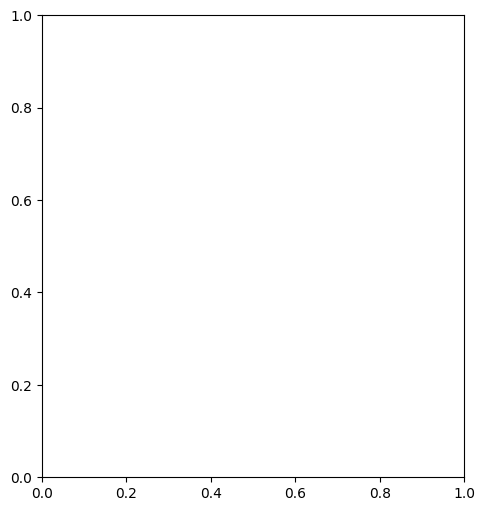

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict labels on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Precision, Recall, F1
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-score: {f1:.4f}")
# Specificity per class
specificity_list = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # Remove row and column i
    fp = np.sum(np.delete(cm[:, i], i))  # Remove the diagonal (true positive)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificity_list.append(specificity)

avg_specificity = np.mean(specificity_list)
print(f" Specificity (avg): {avg_specificity:.4f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/fashion_vgg16_model.h5')


In [ ]:

!pip install gradio --quiet
import gradio as gr
def predict_fashion(img):
    img = img.resize((224, 224))
    img_array = np.array(img).astype(np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    return f"Predicted: {predicted_class}"

iface = gr.Interface(
    fn=predict_fashion,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Fashion Item Classifier (VGG16)",
    description="Upload an image of a fashion item (e.g., shirt, dress, pants) to get the predicted category."
)

iface.launch(share=True)


In [10]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import numpy as np

# Predict probabilities
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Convert probabilities to predicted class labels
train_preds_class = np.argmax(train_preds, axis=1)
val_preds_class = np.argmax(val_preds, axis=1)
test_preds_class = np.argmax(test_preds, axis=1)

# True labels (assuming already integers)
y_train_class = y_train
y_val_class = y_val
y_test_class = y_test

# AUC Scores
train_auc = roc_auc_score(y_train, train_preds, multi_class='ovr')
val_auc = roc_auc_score(y_val, val_preds, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_preds, multi_class='ovr')

# Accuracy
train_accuracy = np.mean(train_preds_class == y_train_class)
val_accuracy = np.mean(val_preds_class == y_val_class)
test_accuracy = np.mean(test_preds_class == y_test_class)

# Loss
train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Precision, Recall, F1-Score (Weighted & Macro)
precision_weighted = precision_score(y_test_class, test_preds_class, average='weighted')
recall_weighted = recall_score(y_test_class, test_preds_class, average='weighted')
f1_weighted = f1_score(y_test_class, test_preds_class, average='weighted')

precision_macro = precision_score(y_test_class, test_preds_class, average='macro')
recall_macro = recall_score(y_test_class, test_preds_class, average='macro')
f1_macro = f1_score(y_test_class, test_preds_class, average='macro')

# Sensitivity = Recall (Weighted)
sensitivity = recall_weighted

# Specificity (approximate for multiclass): TN / (TN + FP) averaged
conf_matrix = confusion_matrix(y_test_class, test_preds_class)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
specificity = np.mean(TN / (TN + FP))

# Classification Miss Rate
miss_rate = 1 - sensitivity

# Output all metrics
print(f"🔹 AUC - Train: {train_auc:.4f}, Validation: {val_auc:.4f}, Test: {test_auc:.4f}")
print(f"🔹 Accuracy - Train: {train_accuracy:.4f}, Validation: {val_accuracy:.4f}, Test: {test_accuracy:.4f}")
print(f"🔹 Loss - Train: {train_loss:.4f}, Validation: {val_loss:.4f}, Test: {test_loss:.4f}")
print(f"🔹 Precision (Weighted): {precision_weighted:.4f}, (Macro): {precision_macro:.4f}")
print(f"🔹 Recall (Sensitivity) (Weighted): {recall_weighted:.4f}, (Macro): {recall_macro:.4f}")
print(f"🔹 F1-Score (Weighted): {f1_weighted:.4f}, (Macro): {f1_macro:.4f}")
print(f"🔹 Specificity (approx): {specificity:.4f}")
print(f"🔹 Classification Miss Rate: {miss_rate:.4f}")
print("\n🔹 Confusion Matrix:\n", conf_matrix)
print("\n🔹 Classification Report:\n", classification_report(y_test_class, test_preds_class))


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
🔹 AUC - Train: 0.9992, Validation: 0.9934, Test: 0.9894
🔹 Accuracy - Train: 0.9657, Validation: 0.9050, Test: 0.8300
🔹 Loss - Train: 0.1086, Validation: 0.3076, Test: 0.3677
🔹 Precision (Weighted): 0.8384, (Macro): 0.8184
🔹 Recall (Sensitivity) (Weighted): 0.8300, (Macro): 0.8100
🔹 F1-Score (Weighted): 0.8323, (Macro): 0.8123
🔹 Specificity (approx): 0.9812
🔹 Classification Miss Rate: 0.1700

🔹 Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  3  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  2]
 [ 0  2  0  0  7  1  0  0  0  0]
 [ 0  0  0  0  0  9  1  0  0  0]
 [ 0  0  0  0  1  0  8  1  0  0]
 [ 0  2  0  0  0  0  0  7  1  0]
 [ 0  0  0  0  0  0  0  1  9  0]
 [ 0  0  0  2  0  0  0  0  0  8]]

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        1

In [9]:
from sklearn.metrics import (
    confusion_matrix, fbeta_score, precision_score, recall_score, f1_score
)
import numpy as np

# Predict classes
test_preds = model.predict(X_test)
test_preds_class = np.argmax(test_preds, axis=1)
y_true = y_test  # assumed to be integer-encoded

# Confusion Matrix
cm = confusion_matrix(y_true, test_preds_class)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Small value to prevent divide-by-zero
eps = 1e-10

# F2-Score (beta=2)
f2_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=2)

# Fβ-Score for general beta (set your desired beta)
beta = 0.5
f_beta_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=beta)

# Positive Predictive Value (Precision)
ppv = precision_score(y_true, test_preds_class, average='weighted')

# Negative Predictive Value (NPV)
npv = np.mean(TN / (TN + FN + eps))

# False Positive Rate (FPR)
fpr = np.mean(FP / (FP + TN + eps))

# False Negative Rate (FNR)
fnr = np.mean(FN / (FN + TP + eps))

# Likelihood Ratios
sensitivity = recall_score(y_true, test_preds_class, average='weighted')
specificity = np.mean(TN / (TN + FP + eps))

lr_positive = sensitivity / (1 - specificity + eps)
lr_negative = (1 - sensitivity) / (specificity + eps)

# Fowlkes–Mallows Index (FMI)
precision_macro = precision_score(y_true, test_preds_class, average='macro')
recall_macro = recall_score(y_true, test_preds_class, average='macro')
fmi = np.sqrt(precision_macro * recall_macro)

# Print Results
print(f"🔹 F2-Score (Weighted): {f2_score_weighted:.4f}")
print(f"🔹 F{beta}-Score (Weighted): {f_beta_score_weighted:.4f}")
print(f"🔹 Positive Predictive Value (PPV): {ppv:.4f}")
print(f"🔹 Negative Predictive Value (NPV): {npv:.4f}")
print(f"🔹 False Positive Rate (FPR): {fpr:.4f}")
print(f"🔹 False Negative Rate (FNR): {fnr:.4f}")
print(f"🔹 Likelihood Ratio Positive (LR+): {lr_positive:.4f}")
print(f"🔹 Likelihood Ratio Negative (LR−): {lr_negative:.4f}")
print(f"🔹 Fowlkes–Mallows Index (FMI): {fmi:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step
🔹 F2-Score (Weighted): 0.8305
🔹 F0.5-Score (Weighted): 0.8354
🔹 Positive Predictive Value (PPV): 0.8384
🔹 Negative Predictive Value (NPV): 0.9812
🔹 False Positive Rate (FPR): 0.0188
🔹 False Negative Rate (FNR): 0.1900
🔹 Likelihood Ratio Positive (LR+): 44.2150
🔹 Likelihood Ratio Negative (LR−): 0.1733
🔹 Fowlkes–Mallows Index (FMI): 0.8142
